# Understanding Megan Rapinoe's World Cup Using Data

I remember Megan Anne Rapinoe constantly being in the news during the 2019 Women’s World Cup. A quick search on YouTube informed me that it is difficult to view highlights of her performances online today i.e. December 12, 2022. In this notebook, we will look at Rapinoe's on-ball actions during matches and try to understand her game from data. To do so, we will use [Statsbomb's event data](https://github.com/statsbomb/open-data). This notebook is in fulfillment of the [mini-challenge](https://uppsala.instructure.com/courses/28112/pages/1-visualising-actions) of the *Visualising Actions* section of the course.

In [27]:
import json
import os
from typing import Optional, List, Dict

import matplotlib.pyplot as plt
import pandas as pd
from mplsoccer import Pitch
from pandas.core.groupby import GroupBy

In [21]:
plt.rcParams["figure.figsize"] = (20, 40)

## Data

As we have done earlier in [00_loading_investigating_world_cup_data.ipynb](./00_loading_investigating_world_cup_data.ipynb), we first need to load the competition information in order to get the competition ID.

In [3]:
statsbomb_dir: str = "../data/statsbomb/data"
competitions_fn: str = "competitions.json"

In [4]:
with open(os.path.join(statsbomb_dir, competitions_fn), "r") as f:
    competitions: list = json.load(f)

In [57]:
competitions_table = pd.DataFrame.from_records(competitions)
competitions_table

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,16,4,Europe,Champions League,male,False,False,2018/2019,2022-08-14T16:57:15.866765,2021-06-13T16:17:31.694,None,2022-08-14T16:57:15.866765
1,16,1,Europe,Champions League,male,False,False,2017/2018,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2021-01-23T21:55:30.425330
2,16,2,Europe,Champions League,male,False,False,2016/2017,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
3,16,27,Europe,Champions League,male,False,False,2015/2016,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
4,16,26,Europe,Champions League,male,False,False,2014/2015,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
5,16,25,Europe,Champions League,male,False,False,2013/2014,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
6,16,24,Europe,Champions League,male,False,False,2012/2013,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2021-07-10T13:41:45.751
7,16,23,Europe,Champions League,male,False,False,2011/2012,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
8,16,22,Europe,Champions League,male,False,False,2010/2011,2022-01-26T21:07:11.033473,2021-06-13T16:17:31.694,None,2022-01-26T21:07:11.033473
9,16,21,Europe,Champions League,male,False,False,2009/2010,2022-02-12T16:13:49.294747,2021-06-13T16:17:31.694,None,2022-02-12T16:13:49.294747


Having manually inspected the `competitions` list, we know that the Women's World Cup has the ID `72`. Let us now write a function to get IDs of all matches that England played in the competition.

In [5]:
required_competition_id: int = 72

In [6]:
matches_dir: str = os.path.join(statsbomb_dir, "matches")

In [7]:
def get_match_ids(comp_id: int, matches_loc: str, req_team: Optional[str] = None) -> list:
    """
    Get the IDs of all matches played in the specified competition.
    The results can be further filtered to return match IDs of the
    specified team.
    :param comp_id:     ID of the competition whose match IDs are to be fetched.
    :param matches_loc: Path to directory where match information is available.
    :param req_team:    Name of the team whose match IDs are to be fetched.
    :return: List of match IDs for the specified competition and (optionally) team.
    """
    matches_fns: list = os.listdir(os.path.join(
        matches_loc, str(comp_id)
    ))

    req_match_ids: list = []
    match_fn: str
    for match_fn in matches_fns:
        with open(os.path.join(
                matches_loc, str(comp_id), match_fn), "r") as jf:
            matches: list = json.load(jf)
            match: dict
            for match in matches:
                match_id: Optional[int] = match["match_id"]
                if req_team:
                    home_team: str = match["home_team"]["home_team_name"]
                    away_team: str = match["away_team"]["away_team_name"]
                    if req_team not in [home_team, away_team]:
                        match_id = None

                req_match_ids.append(match_id)

    return [m_id for m_id in req_match_ids if m_id]

required_team: str = "United States Women's"
required_match_ids: list = get_match_ids(
    required_competition_id,
    matches_loc=matches_dir,
    req_team=required_team
)

Here, we get 7 match IDs. Let us now load event data for all 7 matches.

In [8]:
events_dir: str = os.path.join(statsbomb_dir, "events")

In [9]:
def load_match_events(match_id: int, data_dir: str = "../data/statsbomb/data/events") -> List[dict]:
    """
    Load event data of a match.
    :param match_id: ID of the match which matches the name of the JSON file from which
    to load events
    :param data_dir: Path to the `events` directory of Statsbomb open data.
    :return: A list of dictionaries with each dictionary denoting an event i.e. on-ball action.
    """
    with open(os.path.join(data_dir, f"{match_id}.json"), "r") as jf:
        return json.load(jf)

def frame_events(e: list, match_id: int) -> pd.DataFrame:
    """
    Convert a list of on-ball match events to a Pandas dataframe.
    :param e:        List of dictionaries with each dictionary denoting an event.
    :param match_id: ID of the match whose events are transformed.
    :return: Pandas dataframe of events.
    """
    return (pd.json_normalize(e, sep="_")
            .assign(match_id=match_id))

def load_events(match_ids: list, events_loc: str) -> Dict[str, pd.DataFrame]:
    """
    Load events of each match and save them as a dictionary value.
    :param match_ids:  List of match IDs to fetch events for.
    :param events_loc: Path to directory containing events data.
    :return: A dictionary consisting of events as Pandas dataframes.
    """
    req_events: dict = {}
    m_id: str
    for m_id in match_ids:
        match_events: list = load_match_events(
            match_id=m_id,
            data_dir=events_loc
        )
        framed_match_events: pd.DataFrame = frame_events(match_events, m_id)
        req_events[m_id] = framed_match_events

    return req_events

team_events: dict = load_events(required_match_ids, events_dir)

Finally, let us filter events attributed to Rapinoe.

In [10]:
def filter_events_by_player(events: pd.DataFrame, player_name: str) -> pd.DataFrame:
    """
    Filter events attributed to the specified player.
    :param events:      Pandas dataframe of on-ball events.
    :param player_name: Name of the player.
    :return: Pandas dataframe of events attributed to the player.
    """
    return events.loc[events["player_name"] == player_name]

player_events: dict = {}
player_in_focus: str = "Megan Anna Rapinoe"

mat_id: int
eng_events: pd.DataFrame
for mat_id, eng_events in team_events.items():
    player_events[mat_id] = filter_events_by_player(eng_events, player_in_focus)

In [12]:
player_events[list(player_events.keys())[0]].head()

,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,...,shot_deflected,block_deflection,dribble_overrun,pass_outswinging,foul_committed_card_id,foul_committed_card_name,shot_one_on_one,shot_open_goal,block_offensive,match_id
21,432d7313-db86-48b8-8d70-da4256e16ae1,22,1,00:00:30.600,0,30,3,NaN,42,Ball Receipt*,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22943
22,701968cd-edcc-47b0-8142-f5824eff05f2,23,1,00:00:30.640,0,30,3,1.994601,30,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22943
84,23535584-2396-4470-a79f-d7614628be42,85,1,00:02:15.282,2,15,7,NaN,42,Ball Receipt*,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22943
85,a9a22ac6-165a-48c7-9d0d-3cfc44f1144b,86,1,00:02:15.282,2,15,7,2.297012,43,Carry,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22943
87,ab5973f5-b6ff-4cea-8f34-7bf997a8a717,88,1,00:02:17.579,2,17,7,0.778407,30,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22943


## Visualisations

Before we visualise the data, let us get a list of unique actions that are captured.
Let us begin our visualisations by plotting various actions by Rapinoe in each game.

Before plotting, we drop any rows that have missing `location` column values. This happens when the event type is `Injury stoppage`.

**TODO**:
1. Set markers for specific events
2. Create the same number of plots per match and maintain the order
3. Plot passes with arrows
4. Plot carries by lines

In [16]:
def get_unique_actions(all_events: dict) -> list:
    uniq_actions: list = []
    mt_id: int
    game_events: pd.DataFrame
    for mt_id, game_events in all_events.items():
        uniq_actions.extend(game_events["type_name"].unique().tolist())

    return pd.Series(uniq_actions).unique().tolist()

unique_actions: list = get_unique_actions(player_events)
unique_actions

['Ball Receipt*',
 'Pass',
 'Carry',
 'Pressure',
 'Ball Recovery',
 'Dribble',
 'Miscontrol',
 'Dispossessed',
 'Foul Won',
 'Block',
 'Shot',
 'Dribbled Past',
 'Substitution',
 'Duel',
 'Interception',
 'Foul Committed',
 'Clearance',
 'Shield']

There are 18 unique player actions encoded in the data. Let us define a marker for each to plot scatter plots on the pitch.

In [53]:
select_markers: list = [
    "8",  # 1. octagon
    "s",  # 2. square
    "p",  # 3. pentagon
    "P",  # 4. plus (filled)
    "*",  # 5. star
    "H",  # 6. hexagon
    "D",  # 7. diamond
    "2",  # 8. tri_up
    "^",  # 9. triangle up
    ".",  # 10. point
    "o",  # 11. circle
    "x",  # 12. x
    "X",  # 13. x (filled)
    "+",  # 14. plus
    "_",  # 15. horizontal line
    "|",  # 16. vertical line
    "d",  # 17. thin diamond
    "v"   # 18. triangle down
]
action_markers: dict = dict(zip(unique_actions, select_markers))

Having plotted events for each match separately, we feel that the amount of information on display is overwhelming and does not pop out any insight. Hence, we merge data from all matches together and then plot actions.

In [19]:
player_all_events: pd.DataFrame = pd.concat(player_events.values())
player_all_events.head()

,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,...,miscontrol_aerial_won,pass_miscommunication,pass_no_touch,foul_committed_penalty,foul_won_penalty,injury_stoppage_in_chain,shot_saved_off_target,goalkeeper_shot_saved_off_target,clearance_other,pass_deflected
21,432d7313-db86-48b8-8d70-da4256e16ae1,22,1,00:00:30.600,0,30,3,NaN,42,Ball Receipt*,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,701968cd-edcc-47b0-8142-f5824eff05f2,23,1,00:00:30.640,0,30,3,1.994601,30,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,23535584-2396-4470-a79f-d7614628be42,85,1,00:02:15.282,2,15,7,NaN,42,Ball Receipt*,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,a9a22ac6-165a-48c7-9d0d-3cfc44f1144b,86,1,00:02:15.282,2,15,7,2.297012,43,Carry,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,ab5973f5-b6ff-4cea-8f34-7bf997a8a717,88,1,00:02:17.579,2,17,7,0.778407,30,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
player_all_events[player_all_events["type_name"] == "Shot"]

,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,...,miscontrol_aerial_won,pass_miscommunication,pass_no_touch,foul_committed_penalty,foul_won_penalty,injury_stoppage_in_chain,shot_saved_off_target,goalkeeper_shot_saved_off_target,clearance_other,pass_deflected
2573,7a089b39-ae14-413b-b9c0-6155b8c27a5a,2574,2,00:24:44.889,69,44,155,1.256833,16,Shot,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2945,5c30dbd7-e34f-40c9-8f06-c4fe27d83e09,2946,2,00:33:38.208,78,38,187,0.648700,16,Shot,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1919,ba37c026-ab9d-45b6-a1d3-d20a0f410874,1920,1,00:46:00.884,46,0,95,0.032900,16,Shot,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1416,fb7ca4cd-2a1b-4231-91d0-e13f3790d34f,1417,1,00:40:30.920,40,30,91,0.257800,16,Shot,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,b563cdc9-c306-4036-aae6-5fa50f5a160a,1990,2,00:15:56.992,60,56,137,0.530907,16,Shot,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,823af990-5c7b-435d-b71e-02ea0ef61393,132,1,00:04:42.055,4,42,12,1.324512,16,Shot,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2192,34f70df9-9df3-4be9-916d-e87fff64b0cd,2193,2,00:19:39.133,64,39,152,0.847085,16,Shot,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,0e5b3c7d-e58c-46b1-82c4-a4f5c43d98fe,199,1,00:06:06.236,6,6,12,0.496300,16,Shot,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
345,6c0c712b-ed13-45cc-a0d0-dce1f4c58539,346,1,00:12:48.506,12,48,24,0.374300,16,Shot,...,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN
458,0b4785b5-1ebc-4b9c-9026-8902be38a12e,459,1,00:16:46.329,16,46,32,0.163800,16,Shot,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


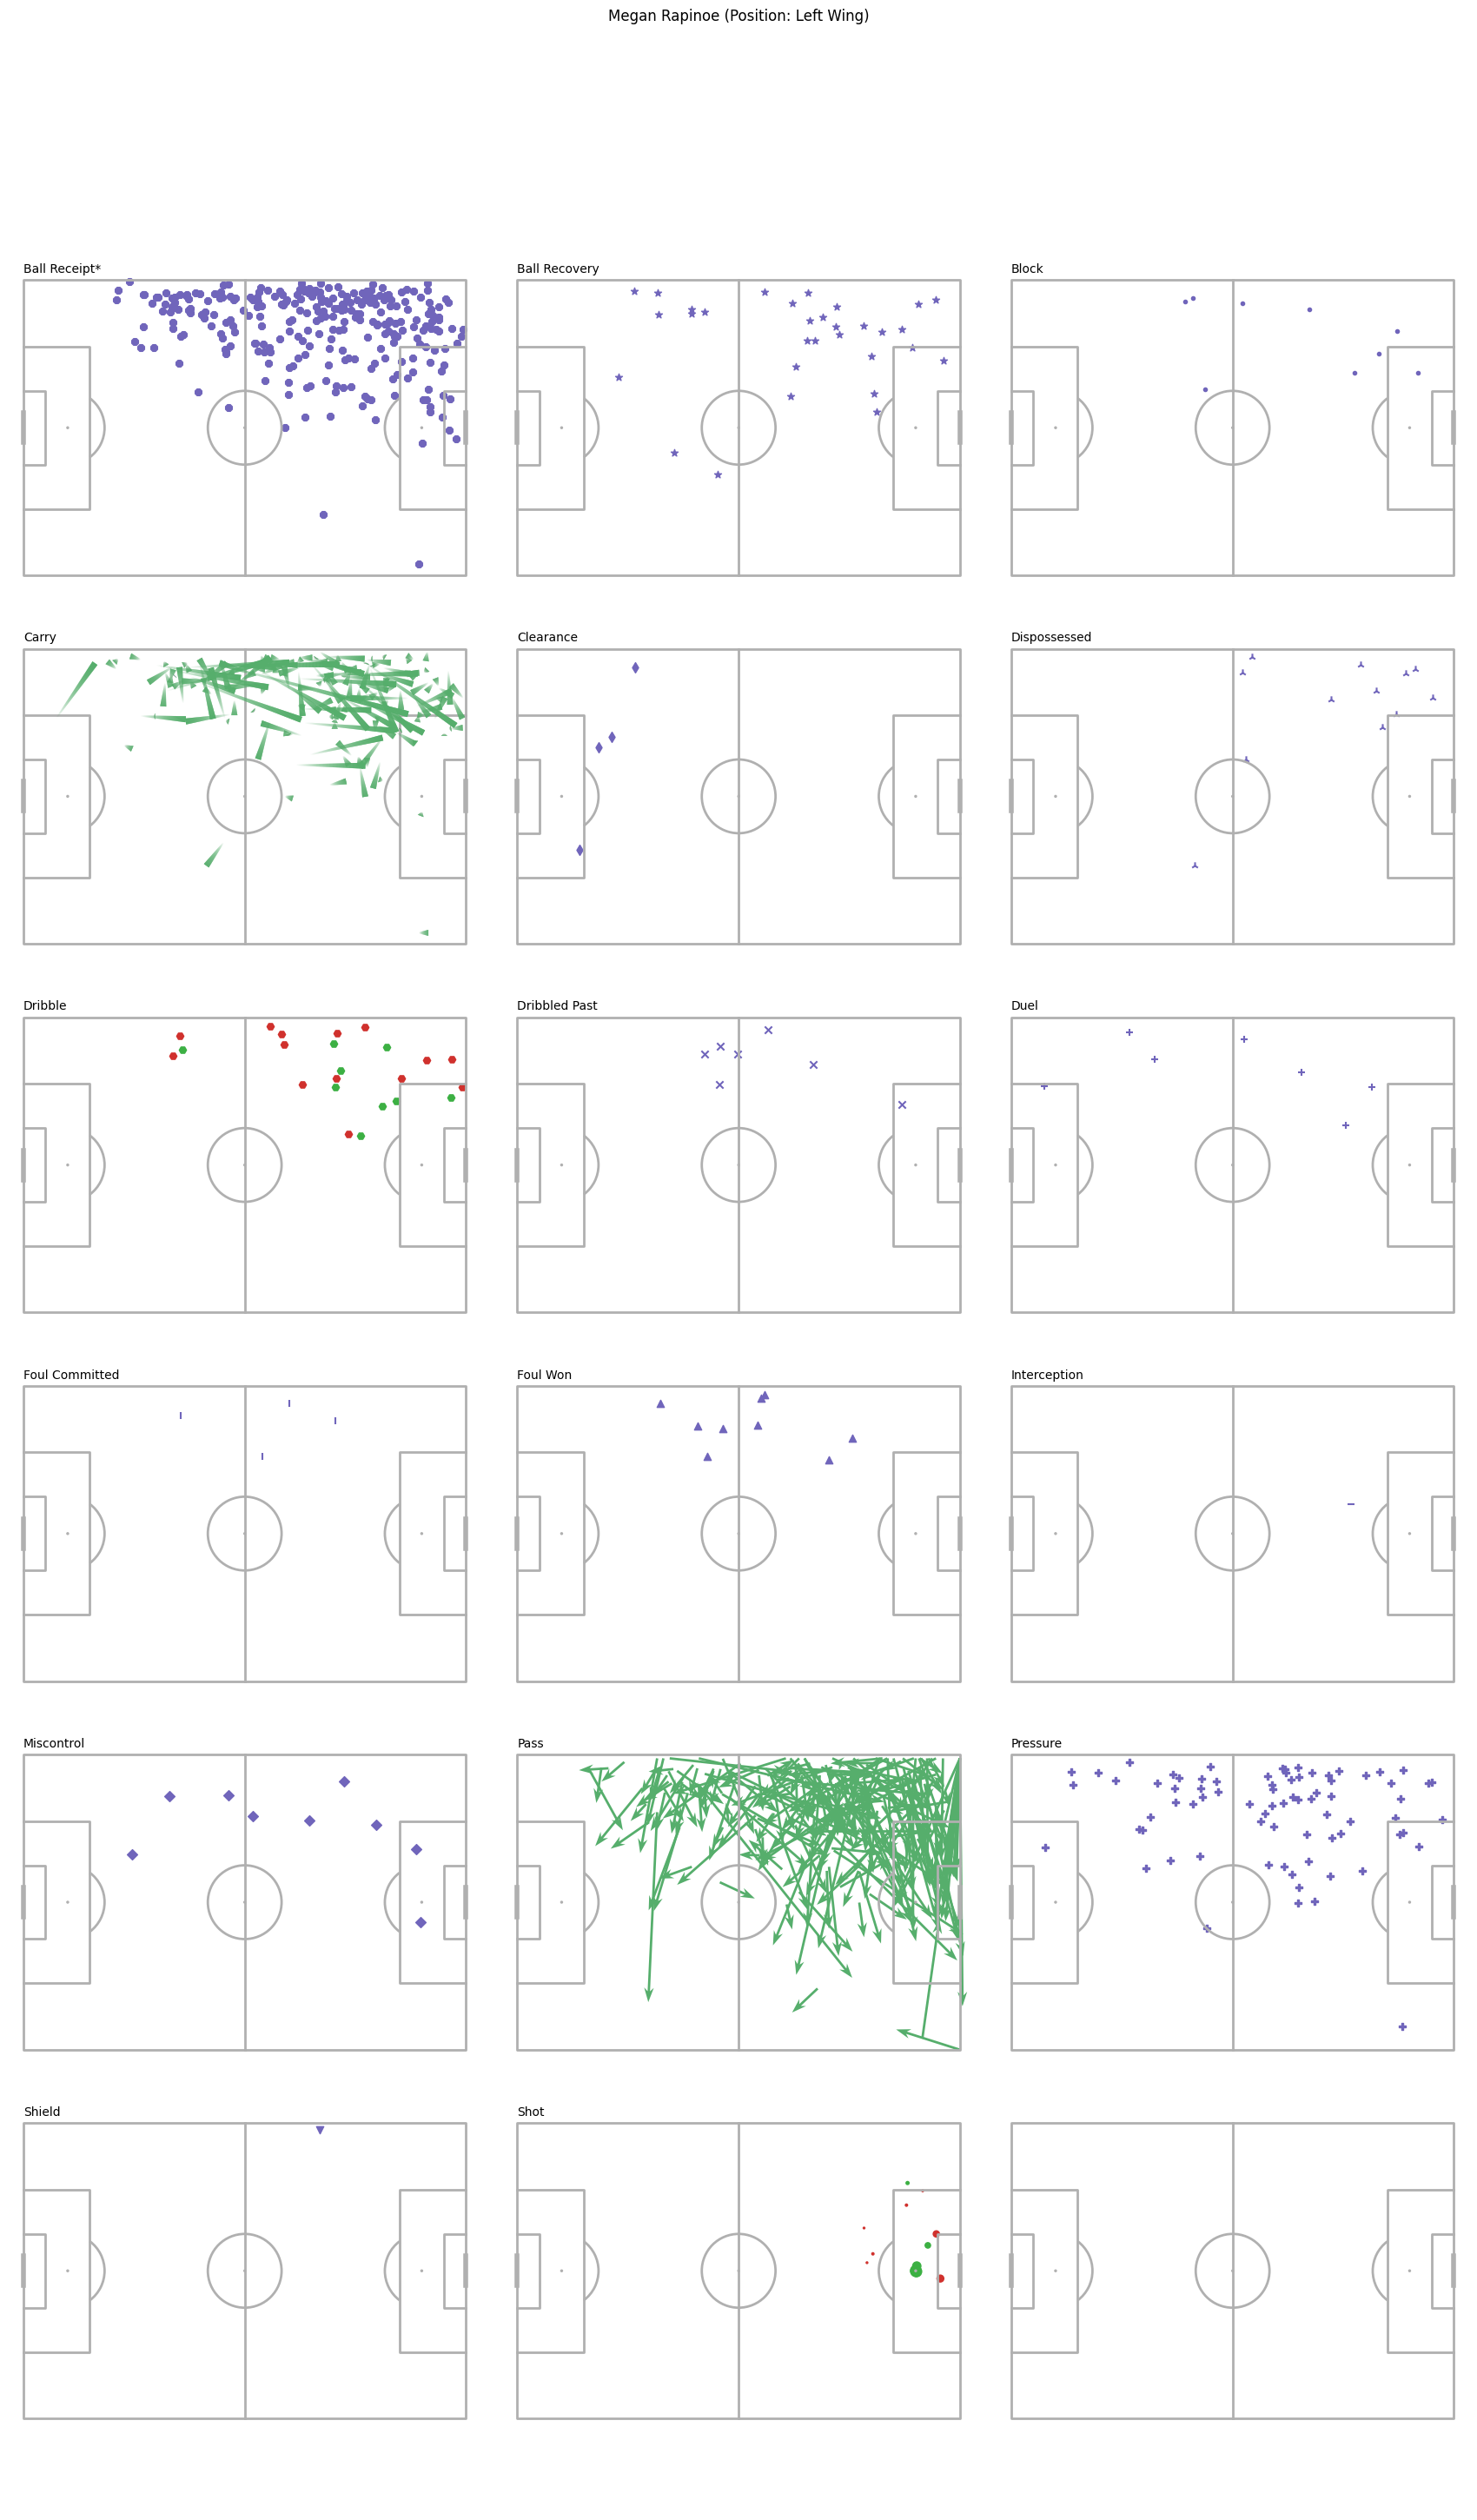

In [55]:
def plot_actions(events: pd.DataFrame, markers: dict):
    player_position: str = events.loc[:, "position_name"].iloc[0]
    events = events.dropna(subset=["location"])
    events_by_action: GroupBy = events.groupby("type_name")

    pitch: Pitch = Pitch(pad_top=10, line_zorder=2)
    fig, axs = pitch.grid(
        nrows=6,
        ncols=3,
        figheight=30,
        endnote_height=0.03,
        endnote_space=0,
        axis=False,
        title_height=0.08,
        grid_height=0.84
    )

    actions: list = list(events_by_action.groups.keys())

    i: int
    for i, ax in enumerate(axs["pitch"].flat):
        try:
            action_name: str = actions[i]
        except IndexError:
            continue
        action_data: pd.DataFrame = events_by_action.get_group(action_name)
        action_locs: list = action_data["location"].to_list()
        x_coords: pd.Series = pd.Series([x[0] for x in action_locs])
        y_coords: pd.Series = pd.Series([x[1] for x in action_locs])

        if action_name == "Pass":
            pass_end_locs: list = action_data["pass_end_location"]
            pass_end_x: list = [x[0] for x in pass_end_locs]
            pass_end_y: list = [x[1] for x in pass_end_locs]
            pitch.arrows(x_coords, y_coords,
                         pass_end_x, pass_end_y,
                         color="#56ae6c", width=2, headwidth=4, headlength=6, ax=ax)
        elif action_name == "Carry":
            carry_end_locs: list = action_data["carry_end_location"]
            carry_end_x: list = [x[0] for x in carry_end_locs]
            carry_end_y: list = [x[1] for x in carry_end_locs]
            pitch.lines(x_coords, y_coords,
                         carry_end_x, carry_end_y,
                         color="#56ae6c", lw=5, transparent=True, comet=True, ax=ax)
        elif action_name == "Dribble":
            mask_dribble_success: pd.Series = action_data["dribble_outcome_id"] == 8.0
            pitch.scatter(x_coords[mask_dribble_success.values], y_coords[mask_dribble_success.values],
                          marker=action_markers[action_name], ax=ax, c="#3cb043")
            pitch.scatter(x_coords[~mask_dribble_success.values], y_coords[~mask_dribble_success.values],
                          marker=action_markers[action_name], ax=ax, c="#d0312d")
        elif action_name == "Shot":
            shot_xg: pd.Series = action_data.loc[action_data["type_name"] == "Shot", "shot_statsbomb_xg"]
            mask_shot_was_goal: pd.Series = action_data["shot_outcome_id"] == 97.0
            pitch.scatter(x_coords[mask_shot_was_goal.values], y_coords[mask_shot_was_goal.values],
                          marker=action_markers[action_name], ax=ax,
                          s=shot_xg[mask_shot_was_goal.values] * 100, c="#3cb043")
            pitch.scatter(x_coords[~mask_shot_was_goal.values], y_coords[~mask_shot_was_goal.values],
                          marker=action_markers[action_name], ax=ax,
                          s=shot_xg[~mask_shot_was_goal.values] * 100, c="#d0312d")
        else:
            pitch.scatter(x_coords, y_coords,
                          marker=action_markers[action_name], ax=ax, c="#7065bb")
        pitch.annotate(action_name, (0, -2), ax=ax)

    fig.suptitle(f"Megan Rapinoe (Position: {player_position})")
    fig.tight_layout()
    plt.show()

plot_actions(player_all_events, action_markers)